In [ ]:
pip install import-ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/Shared drives/ECE765 Group Project')
%cd /content/gdrive/Shared drives/ECE765 Group Project

/content/gdrive/Shared drives/ECE765 Group Project


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import time
import h5py
import joblib
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
import DataPrep_CNN
import torch

In [ ]:
#Build Training Dataset

class TrainingDataset(Dataset):
    def __init__(self):
      self.preimages = read_training_data()
      self.images = normalized_images(self.preimages)
      self.labels = np.array([0] * 4739 + [1] * 4738)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      img = self.images[idx]
      label = self.labels[idx]
      return img, label

def trainDataset():
  train_dataset = TrainingDataset()
  return train_dataset

#Build Validation Dataset

class ValDataset(Dataset):
    def __init__(self):
      self.preimages = read_val_data()
      self.images = normalized_images(self.preimages)
      self.labels = np.array([0] * 500 + [1] * 500)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      img = self.images[idx]
      label = self.labels[idx]
      return img, label

def valDataset():
  val_dataset = ValDataset()
  return val_dataset

In [ ]:
# load training and validation sets
trainImages = torch.load('/content/gdrive/Shared drives/ECE765 Group Project/trainImages_vae.pt')
valImages = torch.load('/content/gdrive/Shared drives/ECE765 Group Project/valImages_vae.pt')
x = trainImages.images.numpy()
x_dataset = x[0:4738]
x_dataset = np.moveaxis(x_dataset,1,3)
x_dataset.shape

(4738, 128, 128, 3)

In [ ]:
def train_pca(X_dataset, n_components, N=4738):
  
    np.random.seed(0)
    index = np.random.choice(len(X_dataset), N, replace=False)
    X_dataset = X_dataset[index]
    
    print('Sample Size: %d' % N)
    print('Data Type X=' + str(X_dataset.dtype))
    print('Shape X=' + str(X_dataset.shape))
    
    pca = PCA(n_components=n_components, whiten=False)
    
    start = time.time()
   
    # Reshape to 1-D array
    shape = X_dataset.shape
    X_reshape = X_dataset.reshape((shape[0], -1)) / 255.
    X_reshape.shape
   
    pca.fit(X_reshape)
    X_pca = pca.transform(X_reshape)
    
    end = time.time()
    elapsed = end - start
    print('Fit time elapsed: {}'.format(elapsed))
    
    return pca
   
n_components = 2000
pca = train_pca(x_dataset, n_components=n_components)

Sample Size: 4738
Data Type X=float32
Shape X=(4738, 128, 128, 3)
Fit time elapsed: 234.42741298675537


In [ ]:
model_path = '/content/gdrive/Shared drives/ECE765 Group Project/pca128_2000comp' 
print('Dumping pca  model to: %s' % model_path) 
joblib.dump(pca, model_path)

Dumping pca  model to: /content/gdrive/Shared drives/ECE765 Group Project/pca128_2000comp


['/content/gdrive/Shared drives/ECE765 Group Project/pca128_2000comp']

In [ ]:
model_path = '/content/gdrive/Shared drives/ECE765 Group Project/pca128_1000comp'
pca = joblib.load(model_path)

In [ ]:
model_path2 = '/content/gdrive/Shared drives/ECE765 Group Project/pca128_200comp'
pca200 = joblib.load(model_path2)

In [ ]:
def display_grid(dataset, digit_size=128, grid_size=3, seed=None):
    # Display some digits to figure out what's going on
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size, 3))
   
    if seed is not None:
        np.random.seed(seed)
    for i in range(grid_size):
        for j in range(grid_size):
            digit = dataset[np.random.randint(len(dataset))]
            d_x, d_y = i * digit_size, j * digit_size
            figure[d_x:d_x + digit_size, d_y:d_y + digit_size, :] = digit.astype(int)
            
    plt.figure(figsize=(7, 7))
    plt.imshow(figure)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Originals


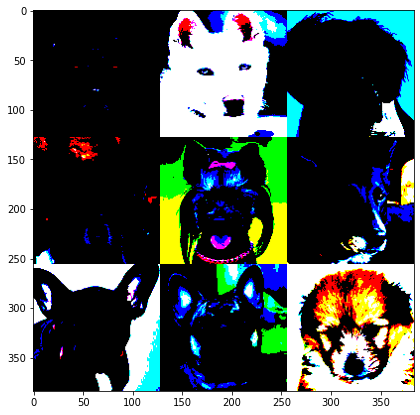

Reconstructed PCA


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


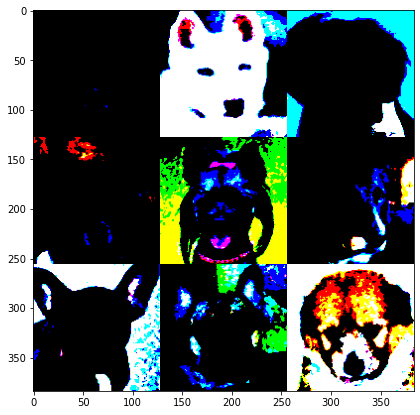

In [ ]:
# display random set of images and their PCA reconstructions
sample_size = 1000
print("Originals")
index = np.random.choice(len(x_dataset), sample_size, replace=False)
dataset = x_dataset[index]
display_grid(dataset, seed=5)

print("Reconstructed PCA")
X_reshape = dataset.reshape((dataset.shape[0], -1)) / 255.
X_pca = pca.transform(X_reshape)
X_recon = np.clip(pca.inverse_transform(X_pca), 0.0, 0.999)
X_recon_reshape = X_recon.reshape(dataset.shape) * 255.
display_grid(X_recon_reshape, seed=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


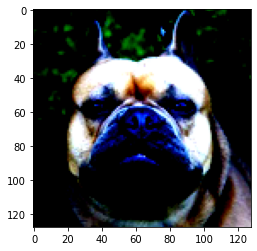

In [ ]:
plt.imshow(x_dataset[index[0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


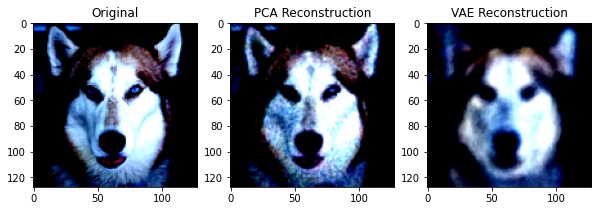

In [ ]:
#image = trainImages.images[29].numpy()
image = valImages.images[0].numpy()
image = np.moveaxis(image,0,2)
image = image
#image = np.moveaxis(image,0,2)
#image = image.reshape(1,128,128,3)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(231)
ax1.title.set_text('Original')
plt.imshow(np.squeeze(image))

ax2 = fig.add_subplot(232)
ax2.title.set_text('PCA Reconstruction')
X_sample = np.stack([image] * 1000)
X_reshape = image.flatten().reshape(1, -1) / 255.
X_pca = pca.transform(X_reshape)
X_recon = np.clip(pca.inverse_transform(X_pca), 0.0, 0.999)
X_recon_reshape = X_recon.reshape(image.shape) * 255.
plt.imshow(np.squeeze(X_recon_reshape))

ax2 = fig.add_subplot(233)
ax2.title.set_text('VAE Reconstruction')
X_sample = np.stack([image] * 1000)
X_reshape = image.flatten().reshape(1, -1) / 255.
X_pca200 = pca200.transform(X_reshape)
X_recon200 = np.clip(pca200.inverse_transform(X_pca200), 0.0, 0.999)
X_recon_reshape200 = X_recon200.reshape(image.shape) * 255.
plt.imshow(np.squeeze(X_recon_reshape200))

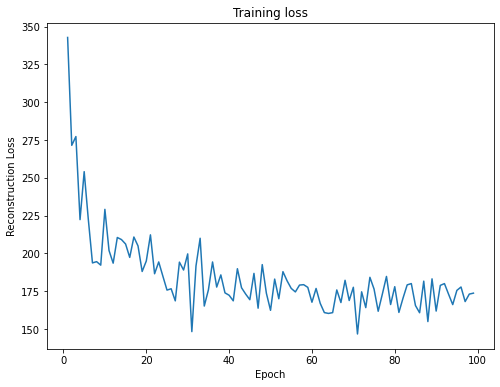

In [ ]:
# plotting training loss
import pandas as pd
history = pd.read_csv('/content/gdrive/Shared drives/ECE765 Group Project/loss.csv')
history['reconstruction_loss'][1:].plot(figsize=(8, 6), ylabel='Reconstruction Loss', xlabel = 'Epoch',
                                        title = 'Training loss')

Text(0.5, 0, 'Image')

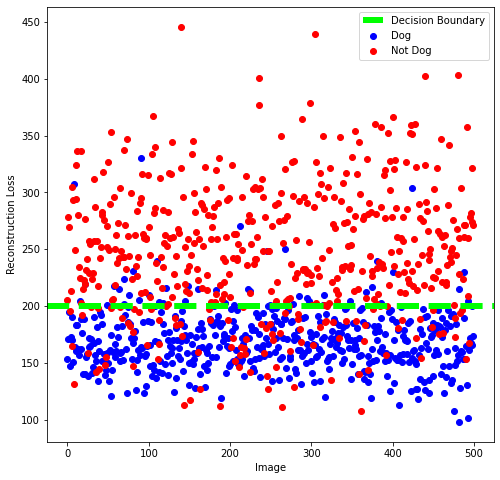

In [ ]:
#visualize predictions on validation set
from scipy.stats import skewnorm
mu_dog = 160
sd_dog = 23
#dogs = sd_dog * np.random.randn(500) + mu_dog
dogs = sd_dog * skewnorm.rvs(.3, loc=0, scale=1, size=500) + mu_dog

# add some outliers to dogs
outliers_x = [8,23,100,245,268,315,400,423,488,380,180,90,110,212] 
outliers_y = [307,155,210,248,250,210,230,304,230,240,200,330,240,270]
for i in range(len(outliers_x)):
  dogs[outliers_x[i]] = outliers_y[i]

mu_not_dog = 250
sd_not_dog = 60
not_dogs = sd_not_dog * np.random.randn(500) + mu_not_dog

fig1 = plt.figure(figsize=(8,8))
ax = plt.scatter(y = dogs, x = range(0,500), color='b', label = 'Dog')  #dogs
ax1 = plt.scatter(y = not_dogs, x = range(0,500), color='r', label = 'Not Dog')  #not dogs
plt.axhline(y=200, color='lime', linestyle='--', linewidth=6, label="Decision Boundary")
plt.legend()
plt.ylabel('Reconstruction Loss')
plt.xlabel('Image')


In [ ]:
tp = sum(i < 200 for i in dogs)
tn = sum(i > 200 for i in not_dogs)
fp = 500 - tn
fn = 500 - tp
print('Accuracy: ' + str((tp + tn)/1000))
print('False-positive Rate: ' + str(fp/(fp+tn)))
print('False-negative Rate:' + str(fn/(fn+tp)))
print('Average reconstruction loss on dogs: '+ str(np.mean(dogs)))
print('Average reconstruction loss on non-dogs: ' + str(np.mean(not_dogs)))

Accuracy: 0.855
False-positive Rate: 0.198
False-negative Rate:0.092
Average reconstruction loss on dogs: 168.79136669745412
Average reconstruction loss on non-dogs: 247.62263872486812


In [ ]:
tn

452